In [1]:
import polars as pl

In [ ]:
def normalize(text: str):
    chars = dict(zip('áéíóúÁÉÍÓÚñÑüÜ','aeiouAEIOUnNuU'))
    trtable = str.maketrans(chars)
    return text.lower().translate(trtable).strip().replace("-", " ").replace("_", " ")

In [29]:
iieg_data = pl.read_parquet("data/iieg_data.parquet").with_columns(
    pl.col("delito").fill_null("").map_elements(normalize).alias("delito"))
sesnsp_data = pl.read_parquet("data/SESNSP/SESNSP_jalisco_data.parquet").with_columns(
    pl.col("Subtipo de delito").fill_null("").map_elements(normalize).alias("Subtipo de delito"))

In [30]:
print(*(col for col in iieg_data.columns if "elito" in col), sep=", ")
print(*(col for col in sesnsp_data.columns if "elito" in col), sep=", ")

delito
Tipo de delito, Subtipo de delito


In [31]:
iieg_delitos = iieg_data["delito"].unique().to_list()
sesnsp_subdelitos = sesnsp_data["Subtipo de delito"].unique().to_list()

In [33]:
def find_partial_matches(list1, list2):
    matches = []
    for item1 in list1:
        for item2 in list2:
            if item1 in item2 or item2 in item1:
                matches.append((item1, item2))
    return matches

delitos = set(map(min, find_partial_matches(iieg_delitos, sesnsp_subdelitos)))
print(delitos, sep=", ")

{'homicidio doloso', 'robo de autopartes', 'feminicidio', 'violencia familiar', 'abuso sexual', 'violacion', 'robo a negocio', 'robo a casa habitacion', 'lesiones dolosas'}


In [34]:
def recategorize(text: str):
    delitos = ('homicidio doloso', 'robo de autopartes', 'feminicidio', 'violencia familiar',
               'abuso sexual', 'violacion', 'robo a negocio', 'robo a casa habitacion', 'lesiones dolosas')
    for delito in delitos:
        if delito in text:
            return delito
    return None

In [38]:
pattern = "|".join(delitos)
iieg_data_filtered = iieg_data.filter(pl.col("delito").str.contains(pattern)).with_columns(pl.col("delito").map_elements(recategorize).alias("crime"))
sesnsp_data_filtered = sesnsp_data.filter(pl.col("Subtipo de delito").str.contains(pattern)).with_columns(pl.col("Subtipo de delito").map_elements(recategorize).alias("crime"))

In [43]:
iieg_2024 = (
    iieg_data_filtered.filter(pl.col("fecha").dt.year() == 2024)
)

sesnsp_2024 = (
    sesnsp_data_filtered.filter(pl.col("Fecha").dt.year() == 2024)
)


iieg_trend = (
    iieg_2024
    .group_by([pl.col("crime"), pl.col("fecha").dt.truncate("1mo").alias("month")])
    .agg(pl.len().alias("iieg_count"))
)

sesnsp_trend = (
    sesnsp_2024
    .group_by([pl.col("crime"), pl.col("Fecha").dt.truncate("1mo").alias("month")])
    .agg(pl.len().alias("sesnsp_count"))
)


trend_comparison = (
    iieg_trend.join(
        sesnsp_trend,
        on=["crime", "month"],
        how="full"
    )
    .fill_null(0)
    .sort(["crime", "month"])
)

trend_comparison

crime,month,iieg_count,crime_right,month_right,sesnsp_count
str,date,u32,str,date,u32
null,null,0,"""feminicidio""",2024-10-01,2
null,null,0,"""feminicidio""",2024-11-01,2
"""abuso sexual""",2024-01-01,450,"""abuso sexual""",2024-01-01,401
"""abuso sexual""",2024-02-01,425,"""abuso sexual""",2024-02-01,395
"""abuso sexual""",2024-03-01,499,"""abuso sexual""",2024-03-01,458
…,…,…,…,…,…
"""violencia familiar""",2024-08-01,1229,"""violencia familiar""",2024-08-01,1229
"""violencia familiar""",2024-09-01,343,"""violencia familiar""",2024-09-01,1235
"""violencia familiar""",2024-10-01,345,"""violencia familiar""",2024-10-01,1248


In [47]:
iieg_data.filter(pl.col("delito") == "feminicidio").filter(pl.col("fecha").dt.year() == 2024).filter(pl.col("fecha").dt.month() == 11)

fecha,delito,x,y,colonia,municipio,clave_mun,hora,bien_afectado,zona_geografica,region
date,str,f64,f64,str,str,i32,time,str,str,str


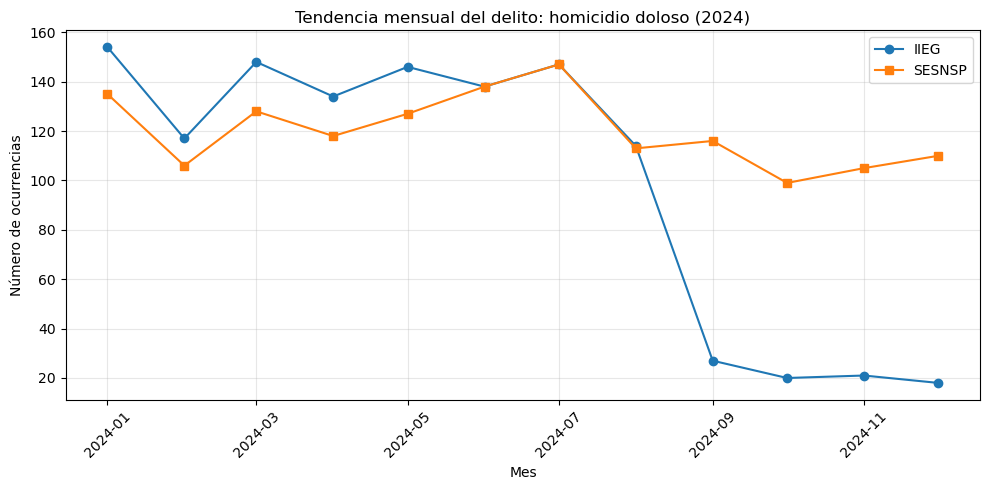

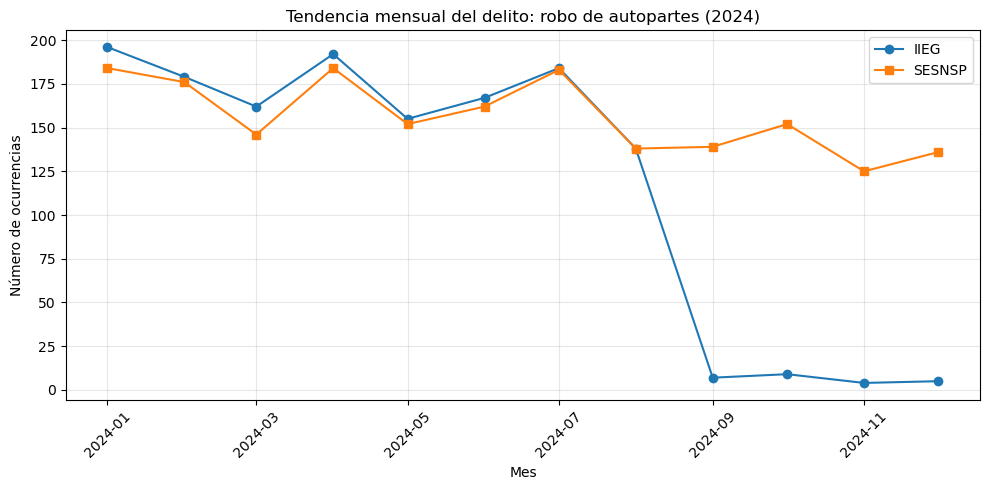

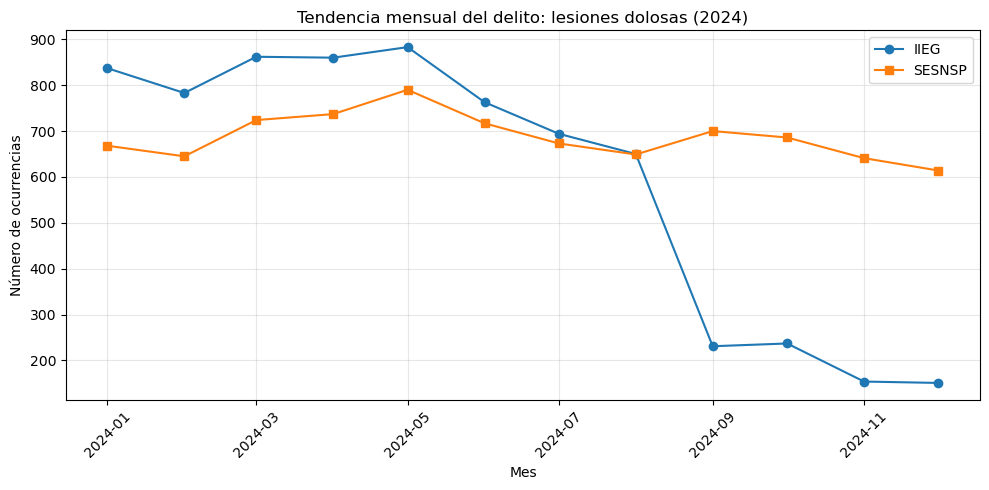

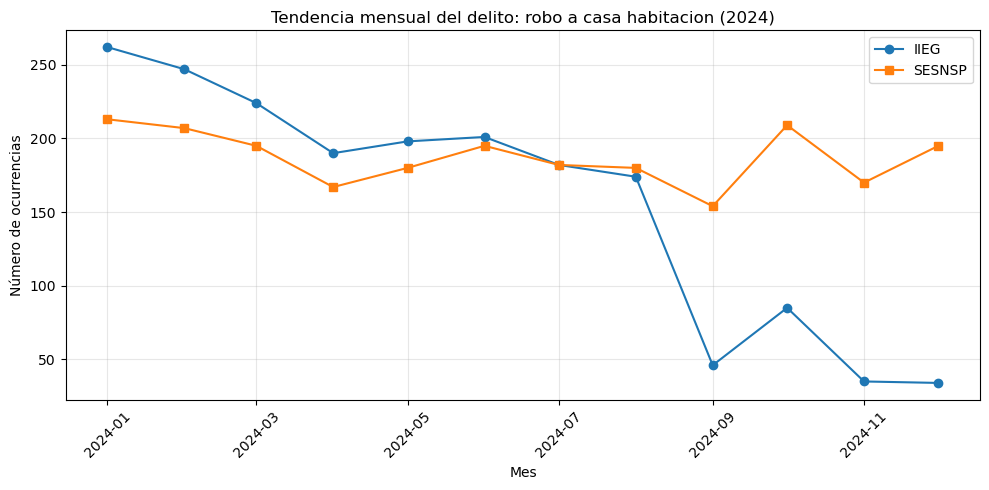

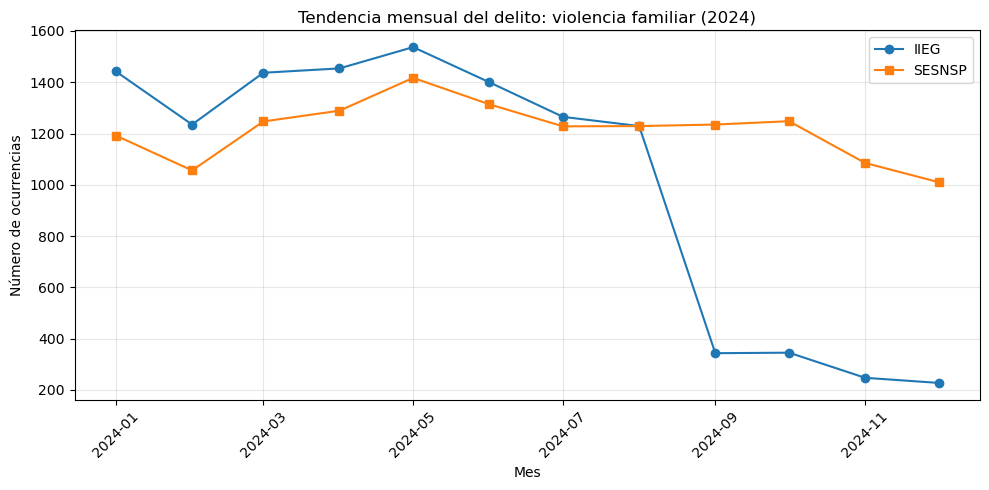

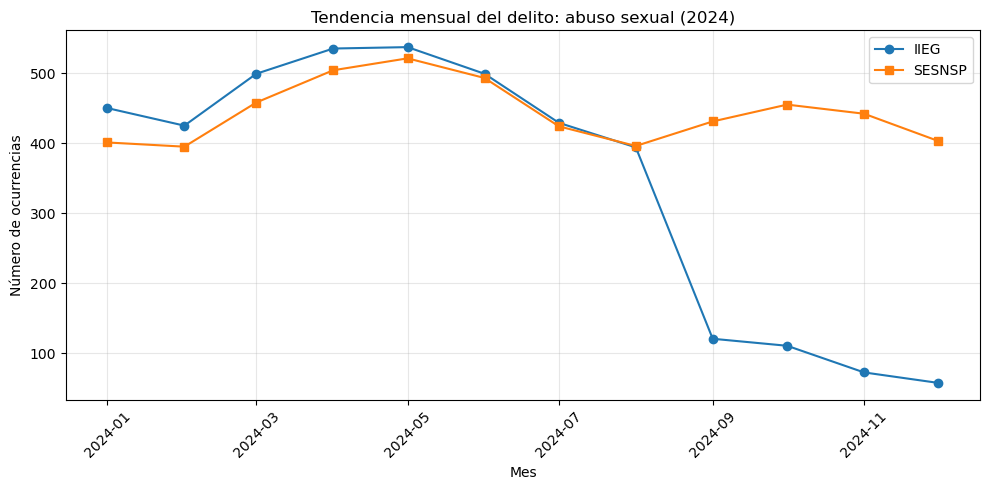

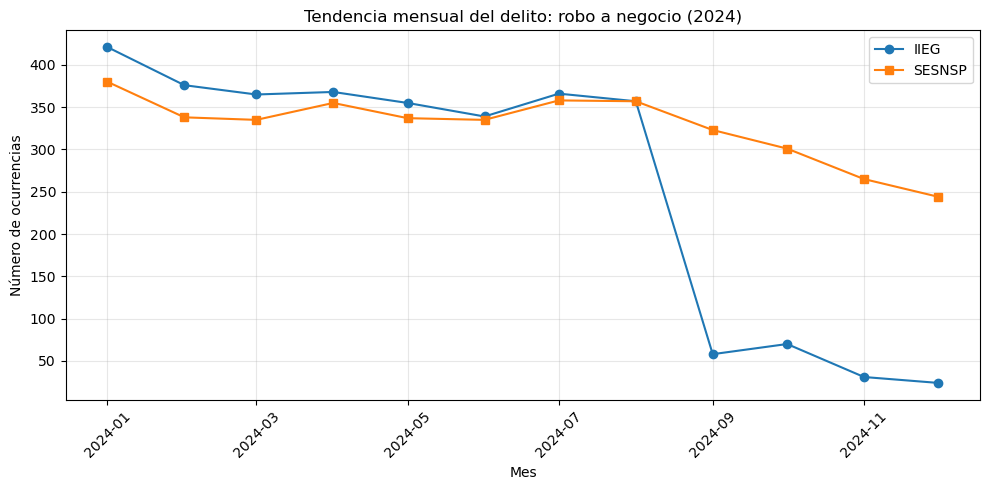

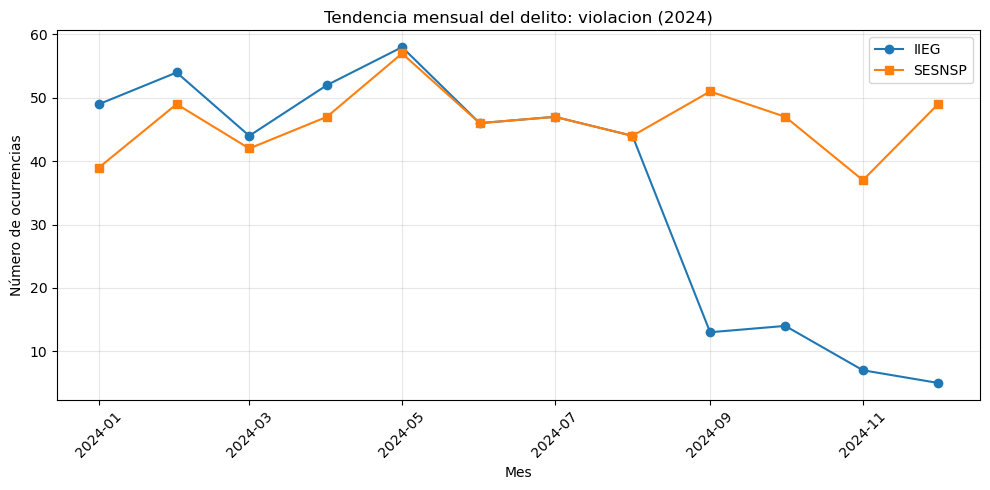

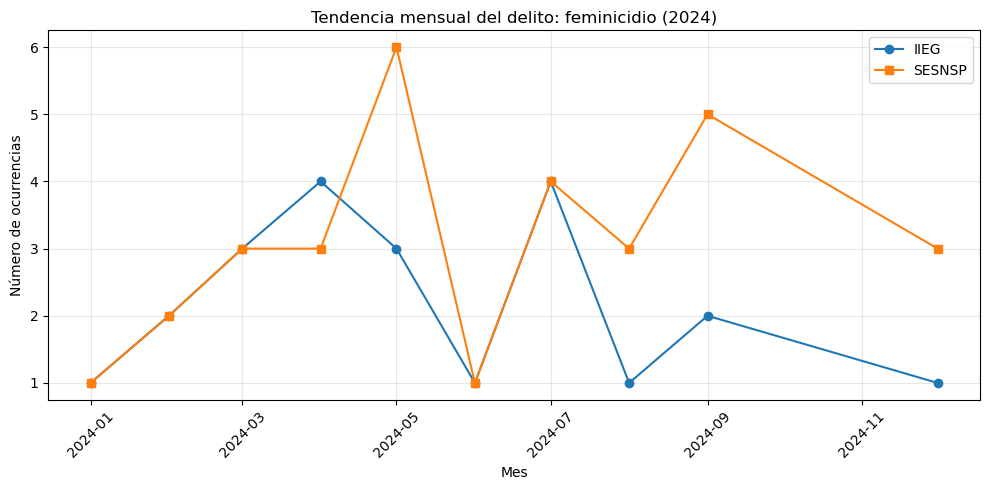

In [49]:
import matplotlib.pyplot as plt


trend_comparison = trend_comparison.sort(["crime", "month"])
crimes = trend_comparison["crime"].unique().to_list()


for crime in crimes:
    if crime is None:
        continue
    df_crime = trend_comparison.filter(pl.col("crime") == crime).sort("month")
    
    months = df_crime["month"].to_list()
    iieg_counts = df_crime["iieg_count"].to_list()
    sesnsp_counts = df_crime["sesnsp_count"].to_list()
    
    plt.figure(figsize=(10,5))
    plt.plot(months, iieg_counts, marker='o', label="IIEG")
    plt.plot(months, sesnsp_counts, marker='s', label="SESNSP")
    
    plt.title(f"Tendencia mensual del delito: {crime} (2024)")
    plt.xlabel("Mes")
    plt.ylabel("Número de ocurrencias")
    plt.xticks(rotation=45)
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()